In [17]:
import numpy as np
import pandas as pd

from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras import callbacks
from keras.layers import Dense,Dropout,BatchNormalization,Convolution1D, MaxPooling1D, Flatten,LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score,roc_curve,auc,f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from art.attacks.evasion import FastGradientMethod, SaliencyMapMethod, BasicIterativeMethod
from art.classifiers import KerasClassifier

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.style.use('bmh')

%matplotlib inline

In [18]:
names=['duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
       'wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
       'root_shell','su_attempted','num_root','num_file_creations','num_shells',
       'num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
       'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
       ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
       'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
       'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
       'connection_type','label']

In [19]:
traindata = pd.read_csv('KDDTrain+.txt',names=names,header=None)
testdata = pd.read_csv('KDDTest+.txt',names=names, header=None)
print("Shape of Train and Test DF : ",traindata.shape," : ",testdata.shape)

Shape of Train and Test DF :  (125973, 43)  :  (22544, 43)


In [20]:
x_train = np.array(traindata.iloc[:,0:41])
x_test = np.array(testdata.iloc[:,0:41])

y_train =  np.array(traindata.iloc[:,42])
y_test = np.array(testdata.iloc[:,42])

print("Shape of Train and Test : ",x_train.shape," : ",x_test.shape)

Shape of Train and Test :  (125973, 41)  :  (22544, 41)


In [21]:
def preOEC(data):
    label_encoder = LabelEncoder()
    for i in range(3):
        data[:,i+1] = label_encoder.fit_transform(data[:,i+1])
    return data

In [22]:
x_train=preOEC(x_train)
x_test=preOEC(x_test)

In [23]:
scaler = Normalizer().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [24]:
y_train_oh= to_categorical(y_train)
y_test_oh= to_categorical(y_test)


In [25]:
x_train_lstm = np.reshape(x_train, (x_train.shape[0],1,x_train.shape[1]))
x_test_lstm = np.reshape(x_test, (x_test.shape[0],1,x_test.shape[1]))
print("Shape of Train and Test : ",x_train.shape," : ",x_test.shape)

Shape of Train and Test :  (125973, 41)  :  (22544, 41)


In [26]:
x_train_cnn = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test_cnn = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
print("Shape of Train and Test : ",x_train.shape," : ",x_test.shape)

Shape of Train and Test :  (125973, 41)  :  (22544, 41)


In [27]:
def printMetrics(true,pred):
    print("Accuracy : ",accuracy_score(true, pred))
    print("Precision",precision_score(true, pred , average="weighted"))
    print("Recall : ",recall_score(true, pred , average="weighted"))
    print("F1-score : ",f1_score(true, pred, average="weighted"))
    print("Confusion Matrix : ")
    print(confusion_matrix(true, pred))

In [28]:
def adversarialFeatures(actual,adversarial,data):
    feats=dict()
    total=0
    orig_attack=actual - adversarial
    for i in range(0,orig_attack.shape [0]) :
        ind=np.where(orig_attack [i,:] != 0) [0]
        total += len(ind)
        for j in ind :
            if j in feats :
                feats [j] += 1
            else :
                feats [j]=1
                
    # The number of features that where changed for the adversarial samples
    print(" Number of unique features changed :",len(feats.keys()))
    print(" Number of average features changed per datapoint ",total / len(orig_attack))

    top_10=sorted(feats,key=feats.get,reverse=True) [:10]
    top_20=sorted(feats,key=feats.get,reverse=True) [:20]


    print(" Top ten features :",data.columns [ top_10 ])

    top_10_val=[100* feats [k ] / y_test.shape [0] for k in top_10 ]
    top_20_val=[100* feats [k ] / y_test.shape [0] for k in top_20 ]


    plt.bar(np.arange(20),top_20_val,align ='center')
    plt.xticks(np.arange(20),data.columns [ top_20 ],rotation ='vertical')
    plt.title('Feature participation in adversarial examples')
    plt.ylabel('Percentage(%)')
    plt.xlabel('Features')

In [29]:
dnnmodel = Sequential()
dnnmodel.add(Dense(1024,input_dim=41,activation='relu'))
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(768,activation='relu'))
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(512,activation='relu')) 
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(256,activation='relu'))
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(128,activation='relu')) 
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(5,activation='softmax'))
dnnmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
dnnmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              43008     
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 768)               787200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 768)               3072      
_________________________________________________________________
dropout_12 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               393728    
__________

In [30]:
cnnmodel = Sequential()
cnnmodel.add(Convolution1D(64, 3, border_mode="same",activation="relu",input_shape=(41, 1)))
cnnmodel.add(Convolution1D(64, 3, border_mode="same", activation="relu"))
cnnmodel.add(MaxPooling1D(pool_length=(2)))
cnnmodel.add(Convolution1D(128, 3, border_mode="same", activation="relu"))
cnnmodel.add(Convolution1D(128, 3, border_mode="same", activation="relu"))
cnnmodel.add(MaxPooling1D(pool_length=(2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(128, activation="relu"))
cnnmodel.add(Dropout(0.5))
cnnmodel.add(Dense(5, activation="softmax"))
cnnmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnnmodel.summary()

d:\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", input_shape=(41, 1), padding="same")`
  
d:\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
d:\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  after removing the cwd from sys.path.
d:\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 3, activation="relu", padding="same")`
  """
d:\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 3, activation="relu", paddi

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 41, 64)            256       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 20, 128)           24704     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
__________

In [31]:
lstmmodel = Sequential()
lstmmodel.add(LSTM(64,input_dim=41, return_sequences=True))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(LSTM(64,return_sequences=True))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(LSTM(64, return_sequences=True))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(LSTM(64, return_sequences=False))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(Dense(5,activation='softmax'))
lstmmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstmmodel.summary()

d:\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, input_shape=(None, 41))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 64)          27136     
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dropout_19 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
__________

In [32]:
'''dnnmodel.load_weights('Colab_run/results/DNN/checkpoint-80.hdf5')
cnnmodel.load_weights('Colab_run/results/CNN/checkpoint-54.hdf5')
lstmmodel.load_weights('Colab_run/results/LSTM/checkpoint-10.hdf5')
'''

"dnnmodel.load_weights('Colab_run/results/DNN/checkpoint-80.hdf5')\ncnnmodel.load_weights('Colab_run/results/CNN/checkpoint-54.hdf5')\nlstmmodel.load_weights('Colab_run/results/LSTM/checkpoint-10.hdf5')\n"

In [33]:
dnnPred = dnnmodel.predict_classes(x_test,verbose=1)
printMetrics(y_test,dnnPred)

22544/22544 [==============================] - 5s 236us/step

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
cnnPred = cnnmodel.predict_classes(x_test_cnn,verbose=1)
printMetrics(y_test,cnnPred)

22544/22544 [==============================] - 3s 117us/step

In [35]:
lstmPred = lstmmodel.predict_classes(x_test_lstm,verbose=1)
printMetrics(y_test,lstmPred)

22544/22544 [==============================] - 2s 109us/step

In [36]:
classifier = KerasClassifier(clip_values=(np.min(x_train), np.max(x_train)), model=dnnmodel)

In [37]:
fgsm = FastGradientMethod(classifier, 
                          eps=.01,
                          minimal=True,
                          eps_step=0.01,
                          num_random_init=35,
                          targeted=False,
                          batch_size=32)

x_test_adv_fgsm = fgsm.generate(x=x_test)

In [38]:
jsma=SaliencyMapMethod(classifier,batch_size=32)
x_test_adv_jsma=jsma.generate(x=x_test)

JSMA:   0%|          | 0/705 [00:00<?, ?it/s]

 Number of unique features changed : 41
 Number of average features changed per datapoint  26.550212916962384
 Top ten features : Index(['service', 'flag', 'srv_count', 'dst_host_count', 'dst_host_srv_count',
       'count', 'same_srv_rate', 'dst_host_same_srv_rate', 'protocol_type',
       'dst_host_diff_srv_rate'],
      dtype='object')


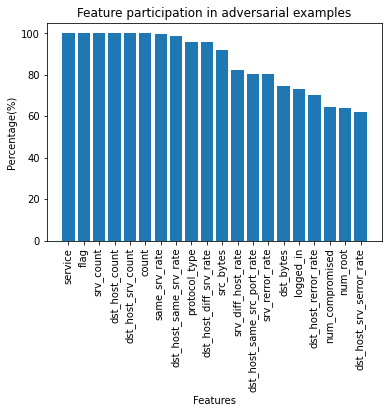

In [39]:
adversarialFeatures(x_test,x_test_adv_fgsm,testdata)

 Number of unique features changed : 41
 Number of average features changed per datapoint  20.140880056777856
 Top ten features : Index(['count', 'srv_count', 'dst_host_count', 'dst_host_srv_count', 'service',
       'flag', 'same_srv_rate', 'protocol_type', 'dst_host_same_srv_rate',
       'src_bytes'],
      dtype='object')


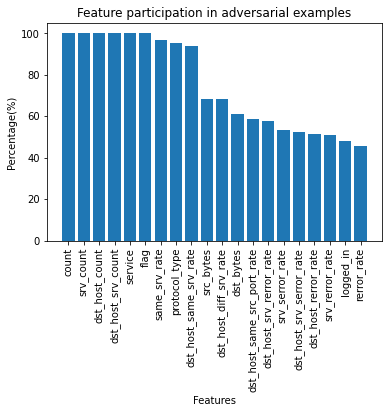

In [40]:
adversarialFeatures(x_test,x_test_adv_jsma,testdata)

In [41]:
dnnpredfgsm = dnnmodel.predict_classes(x_test_adv_fgsm,verbose=1)
dnnpredjsma = dnnmodel.predict_classes(x_test_adv_jsma,verbose=1)
printMetrics(y_test,dnnpredfgsm)
printMetrics(y_test,dnnpredjsma)

22544/22544 [==============================] - 1s 56us/step

In [42]:
x_test_adv_cnn_fgsm = np.reshape(x_test_adv_fgsm, (x_test_adv_fgsm.shape[0],x_test_adv_fgsm.shape[1],1))
x_test_adv_cnn_jsma = np.reshape(x_test_adv_jsma, (x_test_adv_jsma.shape[0],x_test_adv_jsma.shape[1],1))
cnnpredfgsm = cnnmodel.predict_classes(x_test_adv_cnn_fgsm,verbose=1)
cnnpredjsma = cnnmodel.predict_classes(x_test_adv_cnn_jsma,verbose=1)
printMetrics(y_test,cnnpredfgsm)
printMetrics(y_test,cnnpredjsma)

22544/22544 [==============================] - 2s 74us/step

In [43]:
x_test_adv_lstm_fgsm = np.reshape(x_test_adv_fgsm, (x_test_adv_fgsm.shape[0],1,x_test_adv_fgsm.shape[1]))
x_test_adv_lstm_jsma = np.reshape(x_test_adv_jsma, (x_test_adv_jsma.shape[0],1,x_test_adv_jsma.shape[1]))
lstmpredfgsm = lstmmodel.predict_classes(x_test_adv_lstm_fgsm,verbose=1)
lstmpredjsma = lstmmodel.predict_classes(x_test_adv_lstm_jsma,verbose=1)
printMetrics(y_test,lstmpredfgsm)
printMetrics(y_test,lstmpredjsma)

22544/22544 [==============================] - 2s 98us/step

In [44]:
def advMLEval(ML):
    print("\nFGSM\n")
    printMetrics(y_test, ML.predict(x_test_adv_fgsm))
    print("\nJSMA\n")
    printMetrics(y_test, ML.predict(x_test_adv_jsma))

In [45]:
#Machine learning
LR = LogisticRegression()
LR.fit(x_train,y_train)
LR_Predprob=LR.predict_proba(x_test)
LR_Pred=LR_Predprob.argmax(axis=1)
printMetrics(y_test, LR_Pred)
advMLEval(LR)

Accuracy :  0.5245298083747338
Precision 0.3644238525347155
Recall :  0.5245298083747338
F1-score :  0.42173369121852783
Confusion Matrix : 
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     1     0     3     7     0     1   111]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     1    11     0     2    73]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     1     6     0     1    47]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     1    52     0     0    63]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     1     0     2    33     0     6    59]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     2     9    27     0     6    59]
 [    0     0     0     0     0     0

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pred

In [46]:
GNB = GaussianNB()
GNB.fit(x_train,y_train)
GNB_Predprob=GNB.predict_proba(x_test)
GNB_Pred=GNB_Predprob.argmax(axis=1)
printMetrics(y_test, GNB_Pred)
# np.savetxt(LOG_PATH+'GaussianNB/predict_proba.txt', GNB_Predprob, fmt='%06f')
# np.savetxt(LOG_PATH+'GaussianNB/confusion_matrix.txt', confusion_matrix(y_test,GNB_Pred), fmt='%01d')
advMLEval(GNB)

Accuracy :  0.24312455642299502
Precision 0.3451015357240589
Recall :  0.24312455642299502
F1-score :  0.2724425084518677
Confusion Matrix : 
[[  89    0    0    4    4    1    0    1    0    0    6    0    1    0
     0    1    0    0    0    0    0   16]
 [  62    2    2    2    2    0    0    0    0    0    3    0    0    0
     0    0    0    0    5    0    0    9]
 [  37    1    0    0    0    0    0    0    0    0    0    0    3    0
     0    0    0    0    2    0    0   12]
 [  50    0    0    2    2    1    0    0    0    2   33    1    7    0
     0    0    0    1    5    0    0   12]
 [  40    1    0    3    0    1    3    1    0    5   17    3    0    0
     0    1    0    1   14    0    0   11]
 [  30    9    0    5    0    1    4    0    0    0    9    7    1    0
     0    0    0    4   14    0    1   18]
 [  62    7    0   15    1    5    6    0    0    1   16    2   12    0
     0    0    0    6    9    0    0   15]
 [  33    1    0   57    0    5   84    0    1    1  

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
KNN = KNeighborsClassifier()
KNN.fit(x_train,y_train)
KNN_Predprob=KNN.predict_proba(x_test)
KNN_Pred=KNN_Predprob.argmax(axis=1)
printMetrics(y_test, KNN_Pred)
# np.savetxt(LOG_PATH+'KNeighborsClassifier/predict_proba.txt', KNN_Predprob, fmt='%06f')
# np.savetxt(LOG_PATH+'KNeighborsClassifier/confusion_matrix.txt', confusion_matrix(y_test,KNN_Pred), fmt='%01d')
advMLEval(KNN)

Accuracy :  0.595457771469127
Precision 0.5441319054700705
Recall :  0.595457771469127
F1-score :  0.5560597535494152
Confusion Matrix : 
[[    5     2     2     0     0     0     0     2     0     0     0     0
      3     0     2     5     0     2     5    13    37    45]
 [    2     2     3     0     1     0     2     1     0     0     0     0
      2     1     1     3     1     3     2    12    37    14]
 [    0     0     0     7     0     0     0     0     0     0     0     0
      0     0     0     2     1     0     2    13    20    10]
 [    0     3     1    24     0     0     1     0     0     0     0     0
      2     0     1     9     1     2    38    15    13     6]
 [    2     2     0    11     1     0     0     0     1     1     0     0
      1     2     1     6     1     4    15     9    26    18]
 [    0     1     1     2     1     0     2     1     3     1     2     1
      2     0     0     6    12     8     5    16    24    15]
 [    0     1     1     5     2     3   

DT = DecisionTreeClassifier()
DT.fit(x_train,y_train)
DT_Predprob=DT.predict_proba(x_test)
DT_Pred=DT_Predprob.argmax(axis=1)
printMetrics(y_test, DT_Pred)
advMLEval(DT)

In [48]:
AB = AdaBoostClassifier(n_estimators=100)
AB.fit(x_train,y_train)
AB_Predprob=AB.predict_proba(x_test)
AB_Pred=AB_Predprob.argmax(axis=1)
printMetrics(y_test, AB_Pred)
advMLEval(AB)

Accuracy :  0.49525372604684176
Precision 0.35350586044166044
Recall :  0.49525372604684176
F1-score :  0.39874298034379224
Confusion Matrix : 
[[    0     2     0     1     0     0     0     0     1     0     0     1
      0     0     0     2     1     1     9     2    11    92]
 [    0     1     0     1     2     0     0     0     1     0     0     1
      1     0     0     0     0     0     6     1     9    64]
 [    0     0     0     0     0     0     0     1     7     0     0     0
      0     0     0     0     0     0     6     0     0    41]
 [    0     0     0     0     2     0     0     0    24     0     1     0
      1     0     0     0     0     0    30     2     4    52]
 [    0     0     1     0     0     1     0     0    12     0     2     0
      0     0     0     3     3     1    12     0     4    62]
 [    1     0     0     0     0     1     0     0     6     0     0     0
      0     0     0     6     5     3    15     1    11    54]
 [    0     5     0     1     0   

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(x_train,y_train)
RF_Predprob=RF.predict_proba(x_test)
RF_Pred=RF_Predprob.argmax(axis=1)
printMetrics(y_test, RF_Pred)
advMLEval(RF)

Accuracy :  0.6418115684882896
Precision 0.5869439437808608
Recall :  0.6418115684882896
F1-score :  0.5820581652503813
Confusion Matrix : 
[[    0     1     0     0     0     0     0     0     0     0     0     0
      0     1     0     2     0     3     1     3    42    70]
 [    0     3     2     0     0     0     0     0     0     0     0     0
      0     0     0     1     0     5     5     2    53    16]
 [    0     0     1     0     0     0     0     0     0     0     0     0
      0     0     0     1     0     0     2     4    37    10]
 [    0     0     1     1     0     0     0     0     0     0     0     0
      0     0     1     6     0     2    41     5    50     9]
 [    0     0     0     0     1     0     0     0     0     0     0     0
      0     0     1     1     1    12    27     4    36    18]
 [    0     0     0     0     0     0     0     0     0     0     1     0
      1     0     1     1     8     9    20     5    37    20]
 [    0     0     0     0     1     0 

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
LSVM = svm.SVC(kernel='linear',probability=True)
LSVM.fit(x_train,y_train)
LSVM_Predprob=LSVM.predict_proba(x_test)
LSVM_Pred=LSVM_Predprob.argmax(axis=1)
printMetrics(y_test, LSVM_Pred)
advMLEval(LSVM)

In [ ]:
RSVM = svm.SVC(kernel='rbf',probability=True)
RSVM.fit(x_train,y_train)
RSVM_Predprob=RSVM.predict_proba(x_test)
RSVM_Pred=RSVM_Predprob.argmax(axis=1)
printMetrics(y_test, RSVM_Pred)
advMLEval(RSVM)